# Carregamento dos dados da PNAD COVID-19 para um banco PostgreSQL hospedado na AWS (RDS)

O Amazon RDS hospeda o PostgreSQL, permitindo **escalabilidade**, **backups automáticos** e **acesso remoto seguro**.

## Pipeline de Processamento

O pipeline realiza três etapas principais:

1. **Teste de Conexão e Inspeção do Banco**
   - Verifica se a conexão com o banco de dados PostgreSQL está ativa;
   - Lista as tabelas existentes no banco para conferência.

2. **Leitura dos Arquivos CSV e Inserção de Dados**
   - Lê os arquivos CSV contendo os dados da PNAD COVID-19;
   - Cria ou substitui as tabelas no banco com base nesses dados.

3. **Centralização na Nuvem**
   - Os dados são organizados e centralizados na AWS RDS;


In [5]:
import pandas as pd
from sqlalchemy import create_engine, text

#Definição da função para testar conexão
def test_connection(engine):
    try:
        with engine.connect() as connection:
            result = connection.execute(text("SELECT version();"))
            versao = result.fetchone()
            print("Conectado com sucesso:", versao[0])

            result = connection.execute(text("""
                SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';
            """))
            tabelas = result.fetchall()
            print("Tabelas no banco:")
            for tabela in tabelas:
                print("  -", tabela[0])
        return True
    except Exception as e:
        print("Erro ao executar comandos:", e)
        return False

#Função para subir arquivos CSV
def upload_csv_files(engine, arquivos):
    for caminho, tabela in arquivos:
        print(f"Carregando {caminho} para a tabela {tabela}...")
        df = pd.read_csv(caminho)
        df.to_sql(tabela, engine, if_exists='replace', index=False)
        print(f"Tabela {tabela} criada/atualizada com sucesso!")

if __name__ == "__main__":
    #Dados de conexão
    usuario = "postgres"
    senha = "henrique"
    host = "database-2.cbi644kgysev.us-east-1.rds.amazonaws.com"
    porta = 5432
    banco = "fase3"

    engine = create_engine(f"postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}")

    arquivos = [
        ("C:/Users/kurata2/Downloads/PNAD_COVID_082020.csv", "tabela1"),
        ("C:/Users/kurata2/Downloads/PNAD_COVID_092020.csv", "tabela2"),
        ("C:/Users/kurata2/Downloads/PNAD_COVID_102020.csv", "tabela3"),
    ]

    if test_connection(engine):
        upload_csv_files(engine, arquivos)
        print("Todos os arquivos foram carregados!")
    else:
        print("Falha na conexão, abortando upload dos arquivos.")

Conectado com sucesso: PostgreSQL 17.4 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 12.4.0, 64-bit
Tabelas no banco:
  - tabela3
  - tabela1
  - tabela2
Carregando C:/Users/kurata2/Downloads/PNAD_COVID_082020.csv para a tabela tabela1...
Tabela tabela1 criada/atualizada com sucesso!
Carregando C:/Users/kurata2/Downloads/PNAD_COVID_092020.csv para a tabela tabela2...
Tabela tabela2 criada/atualizada com sucesso!
Carregando C:/Users/kurata2/Downloads/PNAD_COVID_102020.csv para a tabela tabela3...
Tabela tabela3 criada/atualizada com sucesso!
Todos os arquivos foram carregados!


# Exportação de Tabelas para Amazon S3 para Camada Raw

Exportação das tabelas do PostgreSQL (RDS) para o Amazon S3, integrando banco de dados e armazenamento em nuvem.

- O **PostgreSQL RDS** hospeda os dados da PNAD COVID-19 de forma **segura**, **escalável** e com **backup automático**;
- O **Amazon S3** é utilizado para armazenar os arquivos CSV, oferecendo **alta disponibilidade**, **versionamento** e **facilidade de acesso** para análises futuras.

## Pipeline de Exportação

O pipeline realiza as seguintes etapas:

1. **Conexão com o Banco de Dados**
   - Estabelece conexão com o banco PostgreSQL hospedado na AWS RDS;
   - Verifica as tabelas disponíveis para exportação.

2. **Leitura e Conversão dos Dados**
   - Lê o conteúdo de cada tabela desejada;
   - Converte os dados em arquivos CSV localmente.

3. **Upload para o Amazon S3**
   - Envia os arquivos CSV para um bucket S3 previamente configurado;
   - Os arquivos são armazenados na pasta `raw/`, correspondente à **camada bruta** dos dados no data lake.



In [6]:
import pandas as pd
from sqlalchemy import create_engine
!pip install boto3
import boto3
from io import StringIO
from botocore.exceptions import ClientError
from getpass import getpass


#Configurações
pg_config = {
    "host": "database-2.cbi644kgysev.us-east-1.rds.amazonaws.com",
    "database": "fase3",
    "user": "postgres",
    "password": "henrique",
    "port": 5432
}

#Bucket S3
bucket_name = "techchallenge3kurata"
s3_prefix = "raw/"
tabelas = ["tabela1", "tabela2", "tabela3"]

#Conexão com o banco
try:
    engine = create_engine(f"postgresql+psycopg2://{pg_config['user']}:{pg_config['password']}@{pg_config['host']}:{pg_config['port']}/{pg_config['database']}")
    print("Conexão com PostgreSQL estabelecida.")
except Exception as e:
    print(f"Erro na conexão com o PostgreSQL: {e}")
    exit(1)

#Conexão com o S3
s3 = boto3.client(
    "s3",
    region_name="us-east-1"
)
region = s3.meta.region_name or "us-east-1"

#Criar bucket S3
try:
    existing_buckets = [b['Name'] for b in s3.list_buckets()['Buckets']]
    if bucket_name in existing_buckets:
        print(f"Bucket '{bucket_name}' já existe.")
    else:
        print(f"Bucket '{bucket_name}' não existe. Criando...")
        if region == "us-east-1":
            s3.create_bucket(Bucket=bucket_name)
        else:
            s3.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
            )
        print(f"Bucket '{bucket_name}' criado com sucesso.")
except Exception as e:
    print(f"Erro ao verificar/criar o bucket: {e}")
    exit(1)

#Exportação das tabelas
for tabela in tabelas:
    print(f"\nExportando: {tabela}")
    try:
        df = pd.read_sql(f"SELECT * FROM {tabela};", engine)
    except Exception as e:
        print(f"Erro ao ler {tabela}: {e}")
        continue

    try:
        buffer = StringIO()
        df.to_csv(buffer, index=False)
        buffer.seek(0)
        s3_key = f"{s3_prefix}{tabela}.csv"
        s3.put_object(Bucket=bucket_name, Key=s3_key, Body=buffer.getvalue())
        print(f"{tabela} enviada para s3://{bucket_name}/{s3_key}")
    except Exception as e:
        print(f"Erro ao enviar '{tabela}' para o S3: {e}")

print("\nExportação finalizada.")


Conexão com PostgreSQL estabelecida.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Bucket 'techchallenge3kurata' já existe.

Exportando: tabela1
tabela1 enviada para s3://techchallenge3kurata/raw/tabela1.csv

Exportando: tabela2
tabela2 enviada para s3://techchallenge3kurata/raw/tabela2.csv

Exportando: tabela3
tabela3 enviada para s3://techchallenge3kurata/raw/tabela3.csv

Exportação finalizada.


# Transformação para Camada Silver

Este notebook processa os dados da PNAD COVID-19, realizando a transformação da **camada raw** para a **camada silver** no bucket do Amazon S3.

## Etapas do Pipeline de Transformação

1. **Leitura dos Dados Brutos (Raw)**
   - Os arquivos CSV armazenados na pasta `raw/` do S3 são lidos diretamente no Python;

2. **Filtragem e Seleção de Colunas**
   - Apenas as colunas relevantes são mantidas;
   - O foco está em preservar informações essenciais para análises, reduzindo o volume de dados e eliminando campos desnecessários.

3. **Conversão e Armazenamento no Formato Parquet**
   - Os DataFrames resultantes são convertidos para o formato **Parquet**, que é mais eficiente para leitura e armazenamento;
   - Os arquivos Parquet são salvos na pasta `silver/` do mesmo bucket S3, organizando os dados de forma estruturada e otimizada para consultas.



In [7]:
###Lê cada CSV da pasta raw/ no bucket.
###Filtra as colunas para manter só as indicadas na lista.
###Salva o resultado em formato Parquet dentro da pasta silver

import boto3
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
from io import BytesIO

#Configurações
bucket_name = "techchallenge3kurata"
raw_prefix = "raw/"
silver_prefix = "silver/"

s3 = boto3.client('s3')

tabelas = ["tabela1", "tabela2", "tabela3"]

#Colunas que você quer manter
colunas_manter = [
    "A002", "A003", "A005", "B0011", "B0014", "B00111", "B002", "B007",
    "B009A", "B009B", "B009C", "V009D", "B009E", "B009F", "B011", "C013",
    "D0031", "F002A1", "F002A2", "F002A3",
    "Ano", "UF", "CAPITAL", "RM_RIDE", "V1008", "V1012", "V1013", "V1016",
    "Estrato", "UPA", "V1022", "V1023", "V1030", "V1031", "V1032", "posest"
]

for tabela in tabelas:
    print(f"Processando {tabela}...")

    #Ler CSV raw do S3
    obj = s3.get_object(Bucket=bucket_name, Key=f"{raw_prefix}{tabela}.csv")
    df = pd.read_csv(obj['Body'])

    #Filtrar só as colunas que queremos, se existirem no DataFrame
    colunas_existentes = [col for col in colunas_manter if col in df.columns]
    df = df[colunas_existentes]

    #Converter DataFrame para Parquet em memória
    table = pa.Table.from_pandas(df)
    parquet_buffer = BytesIO()
    pq.write_table(table, parquet_buffer)
    parquet_buffer.seek(0)

    #Upload para camada silver em Parquet
    s3.put_object(Bucket=bucket_name, Key=f"{silver_prefix}{tabela}.parquet", Body=parquet_buffer.getvalue())
    print(f"{tabela} processada e salva na camada silver.")

print("Processamento da camada silver finalizado.")


Processando tabela1...
tabela1 processada e salva na camada silver.
Processando tabela2...
tabela2 processada e salva na camada silver.
Processando tabela3...
tabela3 processada e salva na camada silver.
Processamento da camada silver finalizado.


# Camada GOLD – Dados Consolidados

Esta etapa do pipeline consolida e enriquece os dados da PNAD COVID-19, transformando-os da **camada silver** para a **camada gold** no Amazon S3.

## Etapas da Consolidação e Enriquecimento

1. **Leitura dos Arquivos Silver**
   - Os arquivos no formato **Parquet** armazenados na pasta `silver/` do S3 são lidos e concatenados;
   - A junção une os dados de diferentes meses em um único DataFrame consolidado.

2. **Filtragem e Padronização**
   - Apenas as **colunas essenciais** são mantidas;
   - Realiza-se limpeza de dados e padronização de nomes, valores e formatos.

3. **Criação de Colunas Derivadas**
   - Novas colunas são criadas com base em regras de negócio e transformação de dados:

4. **Tratamento e Conversão de Tipos**
   - Conversão de tipos de dados para formatos adequados;
   - Preenchimento de valores nulos com defaults apropriados;
   - Garantia de **consistência** nos dados finais.

5. **Armazenamento Final**
   - O DataFrame resultante é salvo em formato **Parquet** na pasta `gold/` do mesmo bucket no S3;



In [8]:
import boto3
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
from io import BytesIO

def criar_gold(bucket_name='techchallenge3kurata', silver_prefix='silver/', gold_prefix='gold/'):
    s3_client = boto3.client('s3')

    print("Listando arquivos na pasta silver...")
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=silver_prefix)
    arquivos = response.get('Contents', [])
    if not arquivos:
        print("Nenhum arquivo encontrado na pasta silver.")
        return None

    dataframes = []
    for obj in arquivos:
        key = obj['Key']
        if not key.endswith('.parquet'):
            print(f"Ignorando arquivo não parquet: {key}")
            continue
        print(f"Lendo arquivo {key}...")
        obj_parquet = s3_client.get_object(Bucket=bucket_name, Key=key)
        parquet_bytes = obj_parquet['Body'].read()
        table = pq.read_table(BytesIO(parquet_bytes))
        df = table.to_pandas()
        dataframes.append(df)

    print(f"Concatenando {len(dataframes)} DataFrames...")
    df_all = pd.concat(dataframes, ignore_index=True)

    #Colunas essenciais que queremos manter e tratar
    colunas_essenciais = [
        'A002', 'A003', 'A005', 'B0011', 'B0014', 'B00111', 'B002', 'B007',
        'B009A', 'B009B', 'B009C', 'B009D', 'B009E', 'B009F', 'B011', 'C013',
        'D0031', 'F002A1', 'F002A2', 'F002A3', 'Ano', 'UF', 'CAPITAL', 'RM_RIDE',
        'V1008', 'V1012', 'V1013', 'V1016', 'Estrato', 'UPA', 'V1022', 'V1023',
        'V1030', 'V1031', 'V1032', 'posest'
    ]
    colunas_existentes = [c for c in colunas_essenciais if c in df_all.columns]
    df_gold = df_all[colunas_existentes].copy()

    #Conversões para numérico onde relevante
    cols_para_numeric = ['A002', 'A003', 'A005', 'B0011', 'B0014', 'B00111', 'B002', 'B007',
                        'B009A', 'B009B', 'B009C', 'B009D', 'B009E', 'B009F', 'B011', 'C013',
                        'D0031', 'F002A1', 'F002A2', 'F002A3']
    for col in cols_para_numeric:
        if col in df_gold.columns:
            df_gold[col] = pd.to_numeric(df_gold[col], errors='coerce')

    #Filtrar linhas com resultado do teste COVID válido (1=positivo, 2=negativo)
    if 'B009B' in df_gold.columns:
        df_gold = df_gold[df_gold['B009B'].isin([1, 2])]
    else:
        print("Coluna B009B (resultado teste) não encontrada!")

    #Criar coluna teste_positivo (1 = positivo, 0 = negativo)
    if 'B009B' in df_gold.columns:
        df_gold['teste_positivo'] = df_gold['B009B'].apply(lambda x: 1 if x == 1 else 0)

    #Criar faixa etária
    if 'A002' in df_gold.columns:
        bins = list(range(0, 140, 10))
        labels = [f"{b}-{b+9}" for b in bins[:-1]]
        df_gold['faixa_idade'] = pd.cut(df_gold['A002'], bins=bins, labels=labels, right=False)
        # Adiciona categoria 'Não informado' para preencher valores nulos
        df_gold['faixa_idade'] = df_gold['faixa_idade'].cat.add_categories('Não informado')


    #Flags booleanas para itens de limpeza/proteção (garantindo booleanos)
    if 'F002A1' in df_gold.columns:
        df_gold['tem_sabao'] = df_gold['F002A1'] == 1
        df_gold['tem_sabao'] = df_gold['tem_sabao'].fillna(False)
    if 'F002A2' in df_gold.columns:
        df_gold['tem_alcool'] = df_gold['F002A2'] == 1
        df_gold['tem_alcool'] = df_gold['tem_alcool'].fillna(False)
    if 'F002A3' in df_gold.columns:
        df_gold['tem_mascara'] = df_gold['F002A3'] == 1
        df_gold['tem_mascara'] = df_gold['tem_mascara'].fillna(False)

    #Home Office e Bolsa Família com mapeamento e limpeza
    if 'C013' in df_gold.columns:
        df_gold = df_gold[df_gold['C013'].isin([1, 2])]
        df_gold['Home_Office'] = df_gold['C013'].map({1: 'Sim', 2: 'Não'})
        df_gold['Home_Office'] = df_gold['Home_Office'].fillna('Não informado')
    else:
        df_gold['Home_Office'] = 'Não informado'

    if 'D0031' in df_gold.columns:
        df_gold = df_gold[df_gold['D0031'].isin([1, 2])]
        df_gold['Bolsa_Familia'] = df_gold['D0031'].map({1: 'Sim', 2: 'Não'})
        df_gold['Bolsa_Familia'] = df_gold['Bolsa_Familia'].fillna('Não informado')
    else:
        df_gold['Bolsa_Familia'] = 'Não informado'

    #Escolaridade com limpeza e map
    escolaridade_map = {
        1:'Sem instrução', 2:'Fundamental incompleto', 3:'Fundamental completa',
        4:'Médio incompleto', 5:'Médio completo', 6:'Superior incompleto',
        7:'Superior completo', 8:'Pós-graduação'
    }
    if 'A005' in df_gold.columns:
        df_gold['Escolaridade'] = df_gold['A005'].map(escolaridade_map)
        df_gold['Escolaridade'] = df_gold['Escolaridade'].fillna('Não informado')
    else:
        df_gold['Escolaridade'] = 'Não informado'

    #Preencher valores nulos restantes para evitar problemas nos gráficos
    df_gold.fillna({
        'faixa_idade': 'Não informado',
        'teste_positivo': 0,
        'tem_sabao': False,
        'tem_alcool': False,
        'tem_mascara': False,
        'Home_Office': 'Não informado',
        'Bolsa_Familia': 'Não informado',
        'Escolaridade': 'Não informado'
    }, inplace=True)

    #Salvar resultado no S3 na pasta gold em Parquet
    print("Convertendo DataFrame final para Parquet e enviando ao S3...")

    table = pa.Table.from_pandas(df_gold)
    parquet_buffer = BytesIO()
    pq.write_table(table, parquet_buffer)
    parquet_buffer.seek(0)

    key_gold = f"{gold_prefix}dados_gold.parquet"
    s3_client.put_object(Bucket=bucket_name, Key=key_gold, Body=parquet_buffer.getvalue())

    print(f"Dados GOLD salvos em s3://{bucket_name}/{key_gold}")

    return df_gold

if __name__ == "__main__":
    df_gold = criar_gold()
    if df_gold is not None:
        print(df_gold.head())
    else:
        print("Não foi possível criar a camada gold.")


if __name__ == "__main__":
    df_gold = criar_gold()



Listando arquivos na pasta silver...
Lendo arquivo silver/tabela1.parquet...
Lendo arquivo silver/tabela2.parquet...
Lendo arquivo silver/tabela3.parquet...
Concatenando 3 DataFrames...
Convertendo DataFrame final para Parquet e enviando ao S3...
Dados GOLD salvos em s3://techchallenge3kurata/gold/dados_gold.parquet
      A002  A003  A005  B0011  B0014  B00111  B002  B007  B009A  B009B  ...  \
161     22     1     6      1      1       1   1.0     1    1.0    1.0  ...   
568     45     1     2      1      1       1   1.0     2    1.0    1.0  ...   
664     37     1     7      2      2       2   NaN     2    1.0    2.0  ...   
767     27     2     7      2      2       2   NaN     1    1.0    1.0  ...   
1209    33     2     5      2      2       2   NaN     2    1.0    2.0  ...   

           V1032  posest  teste_positivo  faixa_idade  tem_sabao  tem_alcool  \
161   193.266241    1113               1        20-29       True        True   
568   260.709017    1115               1       

# Visualização de Dados da Camada GOLD

Este notebook gera visualizações a partir dos dados consolidados da **camada GOLD** da PNAD COVID-19, permitindo identificar padrões e insights relevantes para análises estratégicas.

## Objetivos da Visualização

- Analisar o comportamento da população frente à pandemia com base em:
  - **Home Office**
  - **Escolaridade**
  - **Recebimento do Bolsa Família**
  - **Uso de Itens de Proteção**
  - **Faixa Etária**



Arquivo carregado do S3 com sucesso!
Gerando gráfico: Home Office x Teste Positivo


c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

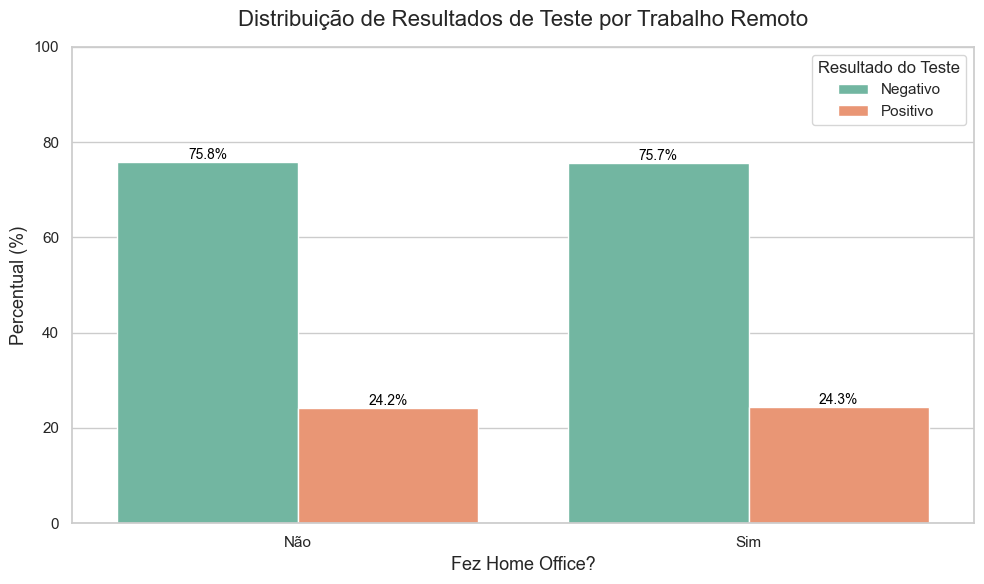

Gerando gráfico: Escolaridade + Bolsa Família x Teste Positivo


c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

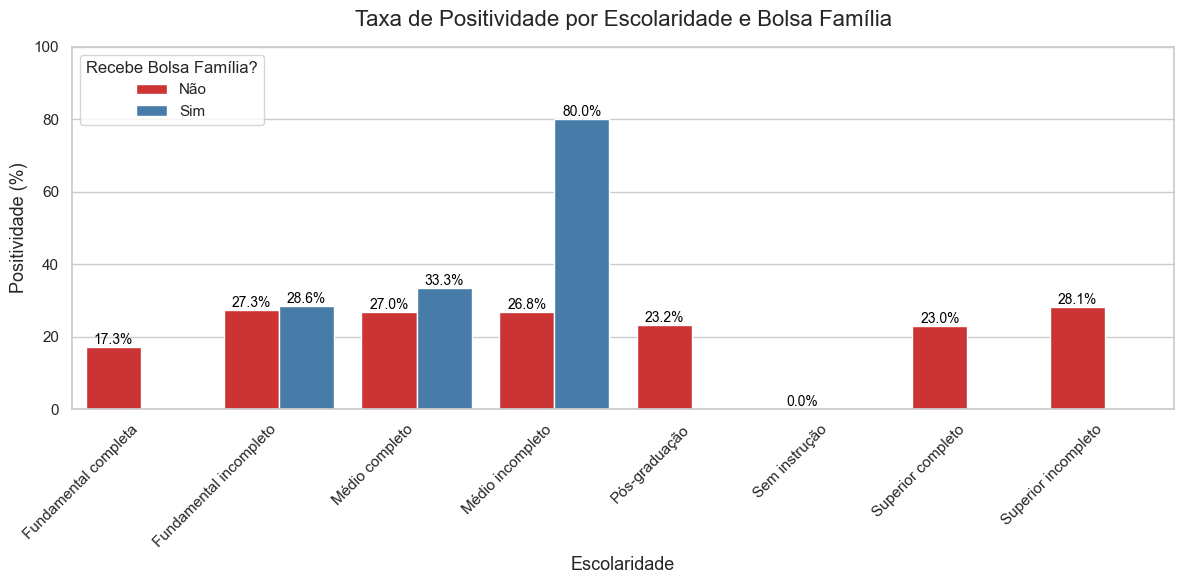

Gerando gráfico: Itens de Proteção x Teste Positivo


c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

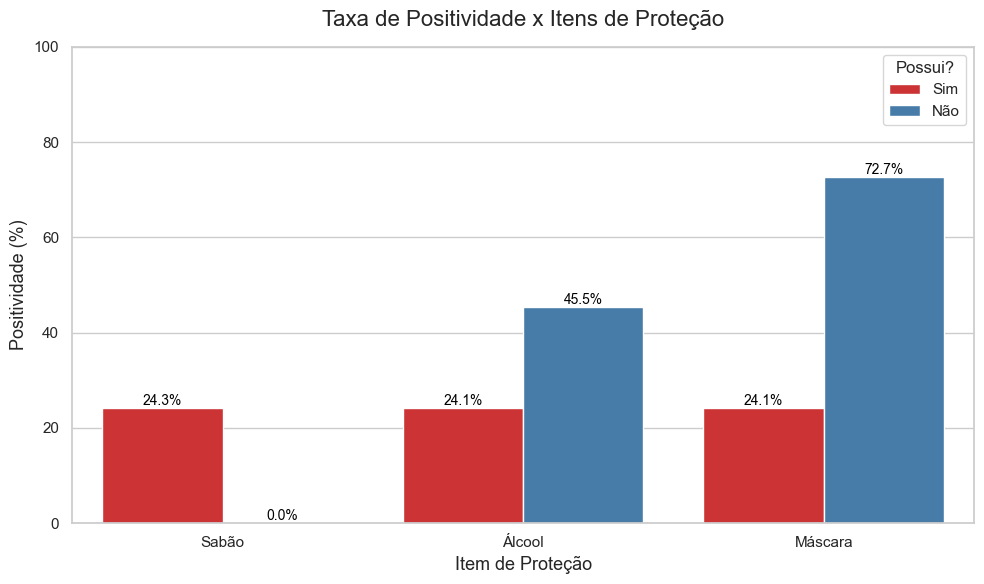

Gerando gráfico: Faixa Etária x Teste Positivo


C:\Users\kurata2\AppData\Local\Temp\ipykernel_14604\1649276098.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_idade = df.groupby('faixa_idade')['teste_positivo'].mean() * 100
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kurata2\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype 

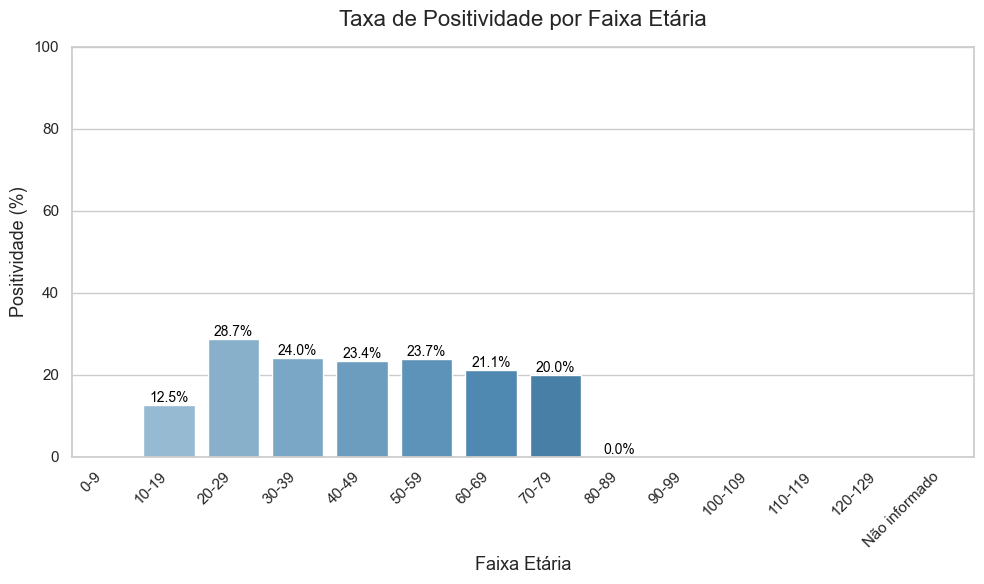

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import pyarrow.parquet as pq
from io import BytesIO

#Configurações S3
bucket_name = "techchallenge3kurata"
gold_key = "gold/dados_gold.parquet"  # Ajuste conforme o nome do arquivo no seu S3

#Inicializa cliente S3
s3 = boto3.client('s3', region_name='us-east-1')

#Leitura do arquivo Parquet do S3
try:
    obj = s3.get_object(Bucket=bucket_name, Key=gold_key)
    parquet_data = obj['Body'].read()
    table = pq.read_table(BytesIO(parquet_data))
    df_gold = table.to_pandas()
    print("Arquivo carregado do S3 com sucesso!")
except Exception as e:
    print(f"Erro ao carregar arquivo do S3: {e}")
    df_gold = None

#Estilo global dos gráficos
sns.set(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlepad": 15,
    "legend.fontsize": 11
})

#Função auxiliar para rótulos nas barras
def adicionar_rotulos(ax, fmt="{:.1f}%"):
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax.annotate(fmt.format(height),
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=10, color='black')

#Gráficos
def grafico_home_office(df):
    df_plot = df.copy()
    df_plot['resultado'] = df_plot['teste_positivo'].map({1: 'Positivo', 0: 'Negativo'})
    resumo = df_plot.groupby(['Home_Office', 'resultado']).size().reset_index(name='count')
    total_por_grupo = resumo.groupby('Home_Office')['count'].transform('sum')
    resumo['percentual'] = (resumo['count'] / total_por_grupo) * 100
    plt.figure()
    ax = sns.barplot(data=resumo, x='Home_Office', y='percentual', hue='resultado', palette='Set2')
    adicionar_rotulos(ax)
    plt.title('Distribuição de Resultados de Teste por Trabalho Remoto')
    plt.ylabel('Percentual (%)')
    plt.xlabel('Fez Home Office?')
    plt.ylim(0, 100)
    plt.legend(title='Resultado do Teste')
    plt.tight_layout()
    plt.show()

def grafico_escolaridade_bolsa(df):
    df_plot = df.copy()
    df_grouped = df_plot.groupby(['Escolaridade', 'Bolsa_Familia'])['teste_positivo'].mean().reset_index()
    df_grouped['Positividade (%)'] = df_grouped['teste_positivo'] * 100
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_grouped,
        x='Escolaridade',
        y='Positividade (%)',
        hue='Bolsa_Familia',
        palette='Set1'
    )
    adicionar_rotulos(ax)
    plt.title('Taxa de Positividade por Escolaridade e Bolsa Família')
    plt.ylabel('Positividade (%)')
    plt.xlabel('Escolaridade')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.legend(title='Recebe Bolsa Família?')
    plt.tight_layout()
    plt.show()

def grafico_protecao(df):
    protecao = ['tem_sabao', 'tem_alcool', 'tem_mascara']
    labels = {'tem_sabao': 'Sabão', 'tem_alcool': 'Álcool', 'tem_mascara': 'Máscara'}
    resultados = []
    for item in protecao:
        if item in df.columns:
            grupo = df.groupby(item)['teste_positivo'].mean() * 100
            resultados.append({
                'Item': labels[item],
                'Possui': 'Sim',
                'Positividade': grupo.get(True, 0)
            })
            resultados.append({
                'Item': labels[item],
                'Possui': 'Não',
                'Positividade': grupo.get(False, 0)
            })
    df_protecao = pd.DataFrame(resultados)
    plt.figure()
    ax = sns.barplot(
        data=df_protecao,
        x='Item',
        y='Positividade',
        hue='Possui',
        palette='Set1'
    )
    adicionar_rotulos(ax)
    plt.title('Taxa de Positividade x Itens de Proteção')
    plt.ylabel('Positividade (%)')
    plt.xlabel('Item de Proteção')
    plt.ylim(0, 100)
    plt.legend(title='Possui?')
    plt.tight_layout()
    plt.show()

def grafico_faixa_idade(df):
    df_idade = df.groupby('faixa_idade')['teste_positivo'].mean() * 100
    df_idade = df_idade.sort_index()
    plt.figure()
    ax = sns.barplot(
        x=df_idade.index.astype(str),
        y=df_idade.values,
        palette='Blues_d'
    )
    adicionar_rotulos(ax)
    plt.title('Taxa de Positividade por Faixa Etária')
    plt.ylabel('Positividade (%)')
    plt.xlabel('Faixa Etária')
    plt.ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def gerar_todos_os_graficos(df):
    print("Gerando gráfico: Home Office x Teste Positivo")
    grafico_home_office(df)
    print("Gerando gráfico: Escolaridade + Bolsa Família x Teste Positivo")
    grafico_escolaridade_bolsa(df)
    print("Gerando gráfico: Itens de Proteção x Teste Positivo")
    grafico_protecao(df)
    print("Gerando gráfico: Faixa Etária x Teste Positivo")
    grafico_faixa_idade(df)

# --- Executa ---
if df_gold is not None:
    gerar_todos_os_graficos(df_gold)
else:
    print("Não foi possível carregar os dados para gerar gráficos.")
